In [1]:
### IMPORT

# lettuce
import lettuce as lt
# unit conversion...

# os and data management
import datetime
import os, shutil
# from pyevtk.hl import imageToVTK
from glob import glob

# calculation
import numpy as np
# torch
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# plotting
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rcParams['agg.path.chunksize'] = 1000

matplotlib.style.use('../figure_style.mplstyle')

In [2]:
### DATA I/O settings
data_base_path = "/home/mbille/Documents/cluster_hbrs_work/21_LBM/01_data"


In [3]:
# PARAMETERS

mas = [0.05, 0.1, 0.2]
res = [10000, 20000, 35000]
gbcs = ['fwbb', 'hwbb', 'ibb']


In [13]:
### CREATE PATH-DICT for all parameter-combinations and respective data on cluster/work/...

paths_dict_ref = dict()
paths_dict_reduced = dict()

for ma in mas:
    for re in res:
        for gbc in gbcs:
            paths_dict_reduced[ma,re,gbc] = []
            paths_dict_ref[ma,re,gbc] = []
            dir_names_reduced = glob(data_base_path + "/*plate_10x10x1PU_HL100_kbc_T20000_" + "Ma" + str(ma)  + "_Re" + str(re) + "_G" + gbc)
            dir_names_ref = glob(data_base_path + "/*REF_plate_full_HL100_kbc_T20000_" + "Ma" + str(ma)  + "_Re" + str(re) + "_G" + gbc)
            
            if len(dir_names_reduced)>1:
                print("(!) Warning: more than 1 simulation for REDUCED:", "Ma" + str(ma)  + "_Re" + str(re) + "_G" + gbc)
                print(dir_names_reduced)
            elif len(dir_names_reduced) == 1:
                # this is what we want: one unique simulation found
                paths_dict_reduced[ma,re,gbc].append(*dir_names_reduced)
            else:
                print("(!) Warning: no path found for REDUCED:", "Ma" + str(ma)  + "_Re" + str(re) + "_G" + gbc)
                
            if len(dir_names_ref)>1:
                print("(!) Warning: more than 1 simulation for REF:", "Ma" + str(ma)  + "_Re" + str(re) + "_G" + gbc)
                print(dir_names_ref)
            elif len(dir_names_ref) == 1:
                # this is what we want: one unique simulation found
                paths_dict_ref[ma,re,gbc].append(*dir_names_ref)
            else:
                print("(!) Warning: no path found for REF:", "Ma" + str(ma)  + "_Re" + str(re) + "_G" + gbc)

In [14]:
### data_series identifiers

# x_positions:
x_positions = [1,2,3]
y_positions = [0,1,2,3]

data_file_prefix = "p_xyz"  # later change to "up_xyz", for sims. after 26.11.24 (!)

In [15]:
print(paths_dict_ref)

{(0.05, 10000, 'fwbb'): ['/home/mbille/Documents/cluster_hbrs_work/21_LBM/01_data/241120_135155-h3d_REF_plate_full_HL100_kbc_T20000_Ma0.05_Re10000_Gfwbb'], (0.05, 10000, 'hwbb'): ['/home/mbille/Documents/cluster_hbrs_work/21_LBM/01_data/241120_135155-h3d_REF_plate_full_HL100_kbc_T20000_Ma0.05_Re10000_Ghwbb'], (0.05, 10000, 'ibb'): ['/home/mbille/Documents/cluster_hbrs_work/21_LBM/01_data/241120_135158-h3d_REF_plate_full_HL100_kbc_T20000_Ma0.05_Re10000_Gibb'], (0.05, 20000, 'fwbb'): ['/home/mbille/Documents/cluster_hbrs_work/21_LBM/01_data/241120_135201-h3d_REF_plate_full_HL100_kbc_T20000_Ma0.05_Re20000_Gfwbb'], (0.05, 20000, 'hwbb'): ['/home/mbille/Documents/cluster_hbrs_work/21_LBM/01_data/241120_135201-h3d_REF_plate_full_HL100_kbc_T20000_Ma0.05_Re20000_Ghwbb'], (0.05, 20000, 'ibb'): ['/home/mbille/Documents/cluster_hbrs_work/21_LBM/01_data/241120_135503-h3d_REF_plate_full_HL100_kbc_T20000_Ma0.05_Re20000_Gibb'], (0.05, 35000, 'fwbb'): ['/home/mbille/Documents/cluster_hbrs_work/21_LBM/

In [25]:
# load timeseries
# i, t, p, ux, uy, uz
# 0, 1, 2, 3 , 4 , 5
pu_timeseries_dict_reduced = dict()
pu_timeseries_dict_ref = dict()

for ma in mas:
    for re in res:
        for gbc in gbcs:
            for x_position in x_positions:
                for y_position in y_positions:
                  #  print("loading:", "Ma"+str(ma),"Re"+str(re),"G"+gbc, "/PU_point_report/"+data_file_prefix+"("+str(x_position)+", "+str(y_position)+",*).txt")
                    
                    # search for string REF:
                    print("searching: ", paths_dict_ref[ma,re,gbc][0]+"/PU_point_report/"+data_file_prefix+"("+str(x_position)+", "+str(y_position)+",*).txt")
                    matches = glob(paths_dict_ref[ma,re,gbc][0]+"/PU_point_report/"+data_file_prefix+"("+str(x_position)+", "+str(y_position)+",*).txt")
                    if len(matches)>1:
                        print("(!) Warning: more than 1 simulation for REF:", "Ma" + str(ma)  + "_Re" + str(re) + "_G" + gbc, "("+str(x_position)+" ," + str(y_position)+")")
                        print(matches)
                    elif len(matches) == 1:
                        # this is what we want: one unique simulation found
                        #OLD: paths_dict[ma,re,gbc].append(*dir_names)
                        pu_timeseries_dict_ref[ma,re,gbc,x_position,y_position] = np.loadtxt(*matches)

                    # serach for string REDUCED:
                    matches = glob(paths_dict_reduced[ma,re,gbc][0]+"/PU_point_report/"+data_file_prefix+"("+str(x_position)+", "+str(y_position)+",*).txt")
                    if len(matches)>1:
                        print("(!) Warning: more than 1 simulation for REDUCED:", "Ma" + str(ma)  + "_Re" + str(re) + "_G" + gbc, "("+str(x_position)+", " + str(y_position)+")")
                        print(matches)
                    elif len(matches) == 1:
                        # this is what we want: one unique simulation found
                        #OLD: paths_dict[ma,re,gbc].append(*dir_names)
                        pu_timeseries_dict_reduced[ma,re,gbc,x_position,y_position] = np.loadtxt(*matches)

searching:  /home/mbille/Documents/cluster_hbrs_work/21_LBM/01_data/241120_135155-h3d_REF_plate_full_HL100_kbc_T20000_Ma0.05_Re10000_Gfwbb/PU_point_report/p_xyz(1, 0,*).txt
searching:  /home/mbille/Documents/cluster_hbrs_work/21_LBM/01_data/241120_135155-h3d_REF_plate_full_HL100_kbc_T20000_Ma0.05_Re10000_Gfwbb/PU_point_report/p_xyz(1, 1,*).txt
searching:  /home/mbille/Documents/cluster_hbrs_work/21_LBM/01_data/241120_135155-h3d_REF_plate_full_HL100_kbc_T20000_Ma0.05_Re10000_Gfwbb/PU_point_report/p_xyz(1, 2,*).txt
searching:  /home/mbille/Documents/cluster_hbrs_work/21_LBM/01_data/241120_135155-h3d_REF_plate_full_HL100_kbc_T20000_Ma0.05_Re10000_Gfwbb/PU_point_report/p_xyz(1, 3,*).txt
searching:  /home/mbille/Documents/cluster_hbrs_work/21_LBM/01_data/241120_135155-h3d_REF_plate_full_HL100_kbc_T20000_Ma0.05_Re10000_Gfwbb/PU_point_report/p_xyz(2, 0,*).txt
searching:  /home/mbille/Documents/cluster_hbrs_work/21_LBM/01_data/241120_135155-h3d_REF_plate_full_HL100_kbc_T20000_Ma0.05_Re10000_Gf

In [30]:
#pu_timeseries_dict_reduced.keys()
plt.close('all')


In [33]:
# plot u_mag and p (top, bottom) of measurement_points against each other

plot_mas = mas
plot_res = res
plot_gbcs = ['fwbb', 'hwbb']  # for d=0.5, ibb produces identical results to hwbb
plot_x_positions = x_positions
plot_y_positions = y_positions

plotting_batch_label = ""  # put as prefix to name before saving...

for ma in plot_mas:
    for re in plot_res:
        for gbc in plot_gbcs:
            for x_position in plot_x_positions:
                for y_position in plot_y_positions:
                    # i, t, p, ux, uy, uz
                    # 0, 1, 2, 3 , 4 , 5
                    # PRESSURE
                    p_fig, p_axs = plt.subplots()
                    p_axs.plot(pu_timeseries_dict_ref[ma,re,gbc,x_position,y_position][:,1], pu_timeseries_dict_ref[ma,re,gbc,x_position,y_position][:,2], marker="", linewidth=0.4, label="FULL domain")
                    p_axs.plot(pu_timeseries_dict_reduced[ma,re,gbc,x_position,y_position][:,1], pu_timeseries_dict_reduced[ma,re,gbc,x_position,y_position][:,2], marker="", linewidth=0.4, label="REDUCED domain")
                    p_axs.set_xlabel("physical time / s")
                    #OLD: ax.set_ylim([0.7,1.7])  #TODO: mal "get" das Limit und dann mit 1e-4 vergleichen und das niedrigere nehmen.
                    #p_axs.set_xlim(left=100)
                    #p_axs.set_xlim([9000,11000])
                    p_axs.set_ylabel("pressure")
                    p_axs.legend(fontsize=5)
                    plt.suptitle("p(t) for Ma" + str(ma)  + "_Re" + str(re) + "_G" + gbc + " at " + "("+str(x_position)+" ," + str(y_position)+")")
                    plt.savefig("/home/mbille/lettuce/plotting_MA/plots/" + plotting_batch_label + "p(t)_Ma" + str(ma)  + "_Re" + str(re) + "_G" + gbc + "_" + "("+str(x_position)+"," + str(y_position)+")" + ".png")
                    plt.close(p_fig)
                    
                    # u_mag
                    u_fig, u_axs = plt.subplots()
                    data_ref = pu_timeseries_dict_ref[ma,re,gbc,x_position,y_position]
                    data_reduced = pu_timeseries_dict_reduced[ma,re,gbc,x_position,y_position]
                    u_axs.plot(data_ref[:,1], np.sqrt(np.square(data_ref[:, 3]) + np.square(data_ref[:, 4]) + np.square(data_ref[:, 5])), marker="", linewidth=0.4, label="FULL domain")
                    u_axs.plot(data_reduced[:,1], np.sqrt(np.square(data_reduced[:, 3]) + np.square(data_reduced[:, 4]) + np.square(data_reduced[:, 5])), marker="", linewidth=0.4, label="REDUCED domain")
                    u_axs.set_xlabel("physical time / s")
                    u_axs.set_ylim([0,0.1])  # bildet die super hohen HWBB-Geschwindigkeiten beim crash nicht voll ab
                    #u_axs.set_xlim(left=100)
                    #u_axs.set_xlim([9000,11000])
                    u_axs.set_ylabel("velocity magnitude")
                    u_axs.legend(fontsize=5)
                    plt.suptitle("u_mag(t) for Ma" + str(ma)  + "_Re" + str(re) + "_G" + gbc + " at " + "("+str(x_position)+" ," + str(y_position)+")")
                    plt.savefig("/home/mbille/lettuce/plotting_MA/plots/" + plotting_batch_label + "u_mag(t)_Ma" + str(ma)  + "_Re" + str(re) + "_G" + gbc + "_" + "("+str(x_position)+"," + str(y_position)+")" + ".png")
                    plt.close(u_fig)
                    

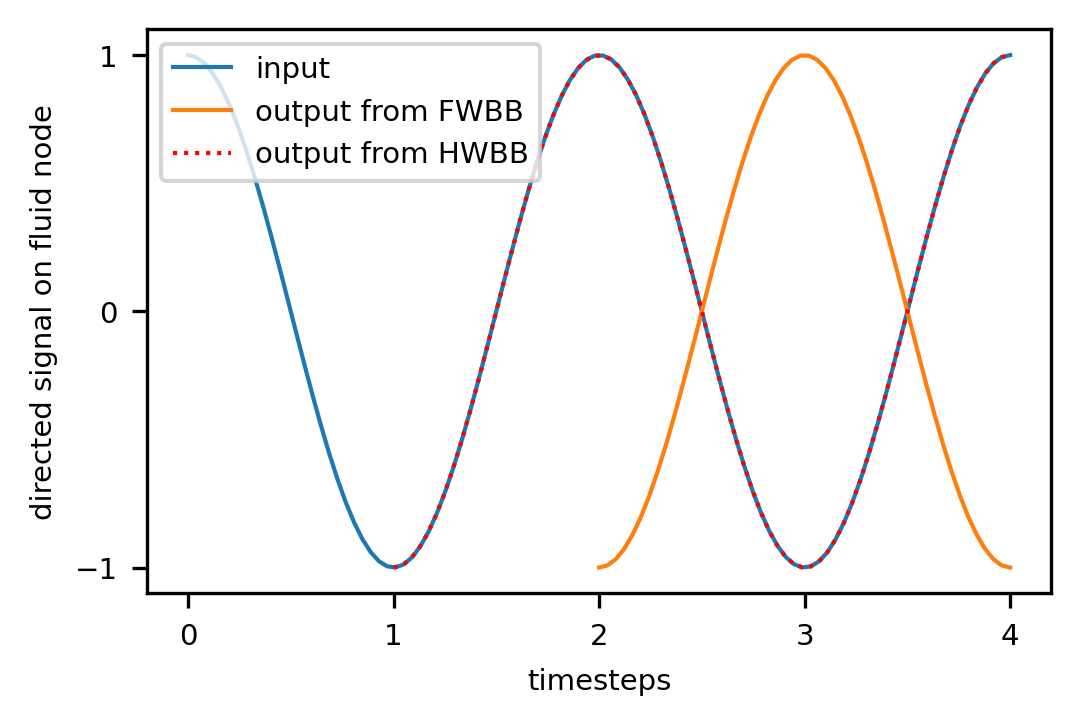

In [11]:
plt.figure()
x_signal = np.linspace(0,4,100)
y_signal = np.cos(x_signal*np.pi)

x_FWBB = np.linspace(2,4,50)
y_FWBB = -np.cos(x_FWBB*np.pi)

x_HWBB = np.linspace(1,4,75)
y_HWBB = np.cos(x_HWBB*np.pi)

plt.plot(x_signal,y_signal, label="input")
plt.plot(x_FWBB,y_FWBB, label="output from FWBB")
plt.plot(x_HWBB,y_HWBB, label="output from HWBB", linestyle=":", color="red")

plt.xticks([0,1,2,3,4])
plt.yticks([-1,0,1])
plt.xlabel("timesteps")
plt.ylabel("directed signal on fluid node")
plt.legend()

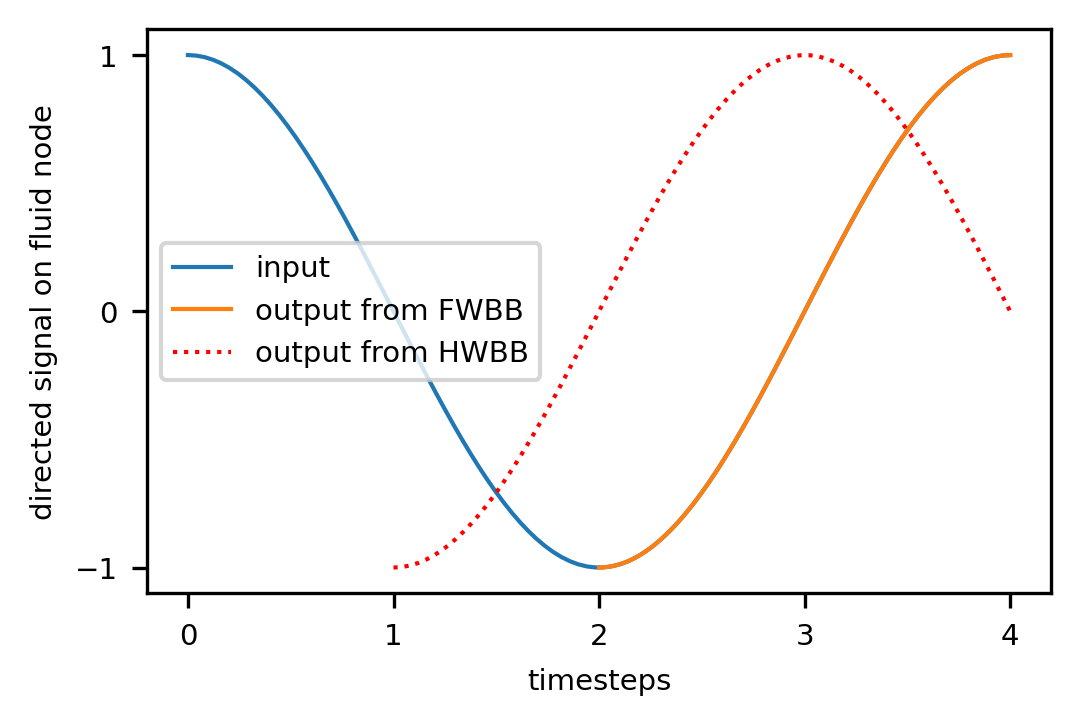

In [18]:
plt.figure()
x_signal = np.linspace(0,4,100)
y_signal = np.cos(x_signal*np.pi/2)

x_FWBB = np.linspace(2,4,50)
y_FWBB = np.cos(x_FWBB*np.pi/2)

x_HWBB = np.linspace(1,4,75)
y_HWBB = -np.cos(x_HWBB*np.pi/2-np.pi/2)

plt.plot(x_signal,y_signal, label="input")
plt.plot(x_FWBB,y_FWBB, label="output from FWBB")
plt.plot(x_HWBB,y_HWBB, label="output from HWBB", linestyle=":", color="red")

plt.xticks([0,1,2,3,4])
plt.yticks([-1,0,1])
plt.xlabel("timesteps")
plt.ylabel("directed signal on fluid node")
plt.legend()

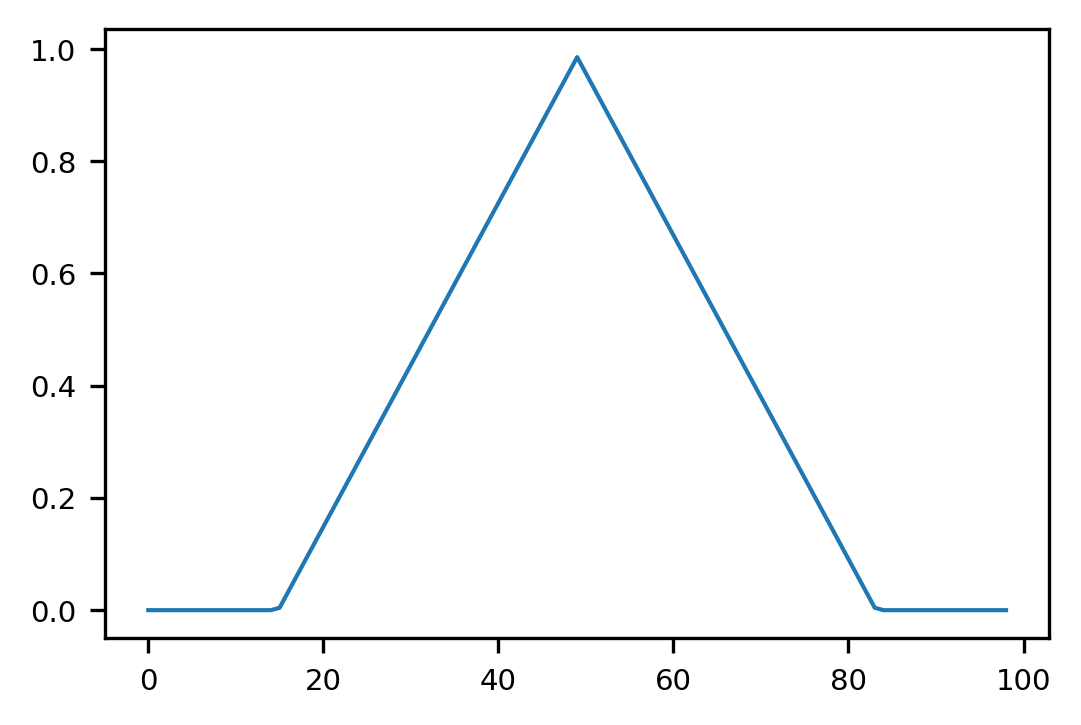

In [27]:
keil_percentage_of_inlet = 0.7
keil_u_max = 1
ny = 99
y = np.linspace(0,ny-1,ny)

#ny = len(y)
y_half = ny/2
y_0 = y_half*(1-keil_percentage_of_inlet)

u_profile = np.where(y<=y_0, 0, keil_u_max*(y-y_0)/(y_half-y_0))
u_profile[int(np.floor(y_half)):] = u_profile[:int(np.ceil(y_half))][::-1]

plt.plot(y, u_profile)

In [17]:
y


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.])